### Import and Install Necessary Packages 

In [1]:
!pip install sagemaker-experiments==0.1.24
!pip install smdebug==0.9.4

     |████████████████████████████████| 176 kB 15.5 MB/s eta 0:00:01


In [2]:
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri
import os 

### Define S3 Bucket and Prefix of Training and Testing Data 

In [3]:
bucket=sagemaker.Session().default_bucket()
prefix = 'demand-prediction'

### Get xgboost 1.0-1 Container 

In [4]:
container = get_image_uri(boto3.Session().region_name, 'xgboost',repo_version="1.0-1")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Produce s3_input object for SageMaker 

In [6]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
(s3_input_train, s3_input_validation)


(<sagemaker.inputs.TrainingInput at 0x7f1dcf82e828>,
 <sagemaker.inputs.TrainingInput at 0x7f1dcff88cf8>)

### Create SageMaker Experiment 

In [7]:
from smexperiments.experiment import Experiment
from sagemaker import get_execution_role
import time 
import boto3

role = get_execution_role()
account_id = role.split(':')[4]
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker',region_name=region)
m5predict_experiment = Experiment.create(
    experiment_name=f"m5-predict-{int(time.time())}", 
    description="Predict the sales units of items", 
    sagemaker_boto_client=sm)
print(m5predict_experiment)


Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f1dd054ac88>,experiment_name='m5-predict-1605692752',description='Predict the sales units of items',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:230755935769:experiment/m5-predict-1605692752',response_metadata={'RequestId': '7a3b965d-d0d6-4a62-ad8e-4b59e4815dca', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7a3b965d-d0d6-4a62-ad8e-4b59e4815dca', 'content-type': 'application/x-amz-json-1.1', 'content-length': '93', 'date': 'Wed, 18 Nov 2020 09:45:52 GMT'}, 'RetryAttempts': 0})


### Define Debugger Hooks and Rules 

In [8]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

## define which kind of tensors to save  
def get_debugger_hook(bucket_path, save_interval):
    return DebuggerHookConfig(
        s3_output_path=bucket_path,  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            )  
        ],
    )

## define when to alert 
def get_debugger_rule(save_interval):
    return [
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ]

### Utility Functions to Observe Metrics Collected

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import re


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()

    tensors = trial.collection(collection_name).tensor_names

    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")
    

In [ ]:

from smexperiments.trial import Trial
import sagemaker
from sagemaker.debugger import rule_configs, Rule
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
from smdebug.trials import create_trial


save_interval = 5
sess = sagemaker.Session()
trial_info = [] 

for i, tree_max_depth in enumerate([1,5,9]):
    # create trial
    trial_name = f"xgboost-training-job-{tree_max_depth}-treemaxdepth-{int(time.time())}"
    xgboost_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=m5predict_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    
    bucket_path = 's3://{}/{}'.format(bucket,trial_name)
    debugger_hook_config_xgboost=get_debugger_hook(bucket_path, save_interval)
    debug_rules=get_debugger_rule(save_interval)

    

    xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess,
                                    debugger_hook_config=debugger_hook_config_xgboost,
                                    rules=debug_rules)
    xgb.set_hyperparameters(max_depth=tree_max_depth,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        num_round=20)
    
    xgboost_training_job_name = "m5predict-xgboost-training-job-{}".format(int(time.time()))
    
    
    xgb.fit(
        inputs={'train': s3_input_train, 'validation': s3_input_validation},
        job_name=xgboost_training_job_name,
        experiment_config={
            "TrialName": xgboost_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    s3_output_path = xgb.latest_job_debugger_artifacts_path()
    trial_info.append((trial_name, s3_output_path))

    # give it a while before dispatching the next training job
    time.sleep(2)




See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: m5predict-xgboost-training-job-1605692766


2020-11-18 09:46:06 Starting - Starting the training job...
2020-11-18 09:46:10 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*
****************************************
.........
2020-11-18 09:47:55 Starting - Preparing the instances for training...
2020-11-18 09:48:35 Downloading - Downloading input data......
2020-11-18 09:49:37 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[0

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: m5predict-xgboost-training-job-1605693144


2020-11-18 09:52:24 Starting - Starting the training job...
2020-11-18 09:52:49 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*
****************************************
.........
2020-11-18 09:54:10 Starting - Preparing the instances for training......
2020-11-18 09:55:11 Downloading - Downloading input data...
2020-11-18 09:55:52 Training - Downloading the training image...
2020-11-18 09:56:12 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV inp

loading s3://sagemaker-us-east-1-230755935769/xgboost-training-job-1-treemaxdepth-1605692766/m5predict-xgboost-training-job-1605692766/debug-output of trial:xgboost-training-job-1-treemaxdepth-1605692766
[2020-11-18 12:19:04.932 ip-172-16-90-51:5469 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-230755935769/xgboost-training-job-1-treemaxdepth-1605692766/m5predict-xgboost-training-job-1605692766/debug-output
[2020-11-18 12:19:08.680 ip-172-16-90-51:5469 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-11-18 12:19:09.749 ip-172-16-90-51:5469 INFO trial.py:210] Loaded all steps
loading s3://sagemaker-us-east-1-230755935769/xgboost-training-job-5-treemaxdepth-1605693144/m5predict-xgboost-training-job-1605693144/debug-output of trial:xgboost-training-job-5-treemaxdepth-1605693144
[2020-11-18 12:19:11.482 ip-172-16-90-51:5469 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-230755935769/xgboo

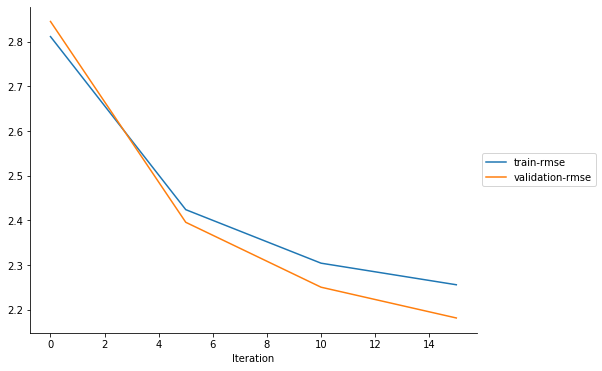

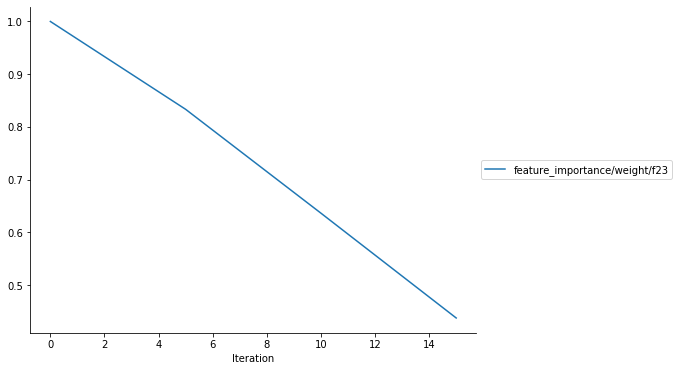

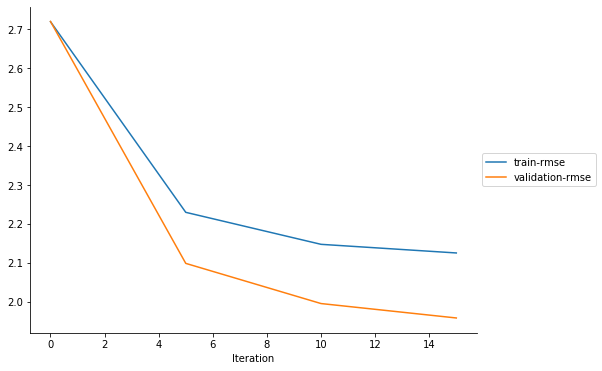

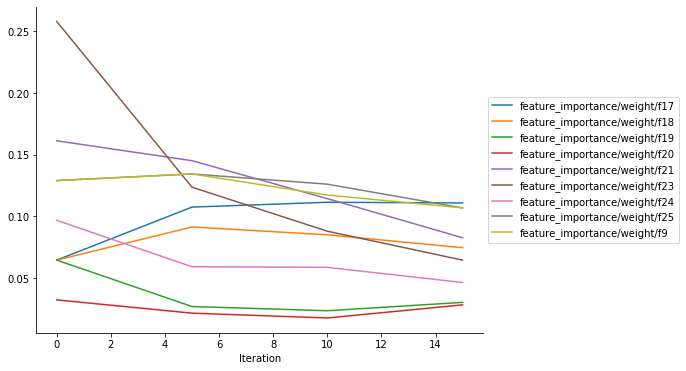

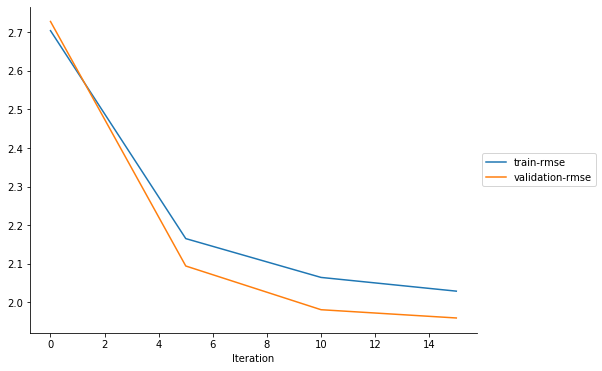

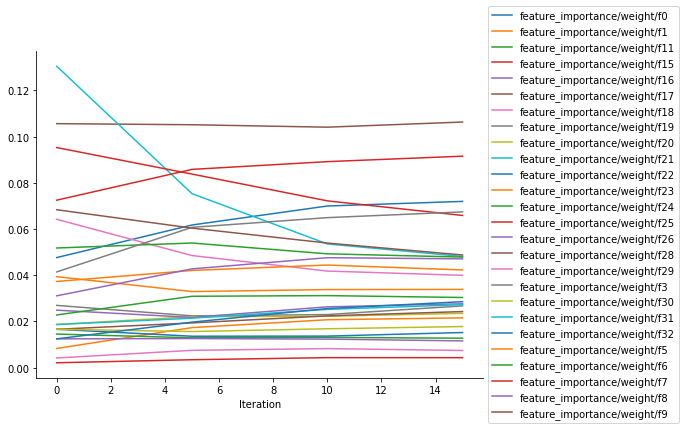

In [12]:
for trial_name, s3_output_path in trial_info: 
    print("loading {} of trial:{}".format(s3_output_path, trial_name))
    trial = create_trial(s3_output_path)
    plot_collection(trial, "metrics")
    plot_feature_importance(trial)